# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [3]:
# os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
# import cupy as cp

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [5]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [10]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

In [63]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    """
    result = array.copy()
    result[mask] = value
    return result

## Inputs & Data

Explanation of each input and where it comes from.

In [12]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [13]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [14]:
zscore_threshold = 4
VOLTAGE_SCALING_VALUE = 0.195

In [15]:
BAND_TO_FREQ = {"theta": (4,12), "gamma": (30,51)}

In [16]:
LFP_TRACES_DF = pd.read_pickle("./proc/rce_pilot_2_01_lfp_traces_and_frames.pkl")

In [17]:
LFP_TRACES_DF.shape

(61, 23)

## Preprocessing

In [18]:
original_trace_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col]

In [19]:
original_trace_columns

['mPFC_lfp_trace',
 'MD_lfp_trace',
 'LH_lfp_trace',
 'BLA_lfp_trace',
 'vHPC_lfp_trace']

In [20]:
for col in original_trace_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: x.astype(np.float32) * VOLTAGE_SCALING_VALUE)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [21]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,lfp_timestamps,mPFC_lfp_trace,MD_lfp_trace,LH_lfp_trace,BLA_lfp_trace,vHPC_lfp_trace
0,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[95.354996, 82.09499, 97.5, 132.405, 123.825, ...","[46.019997, 49.335, 75.27, 97.89, 77.61, 40.55...","[61.425, 66.104996, 81.899994, 90.479996, 71.5...","[54.6, 54.405, 73.32, 86.189995, 59.085, 19.89...","[55.574997, 79.365, 128.11499, 170.43, 189.344..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[95.354996, 82.09499, 97.5, 132.405, 123.825, ...","[46.019997, 49.335, 75.27, 97.89, 77.61, 40.55...","[61.425, 66.104996, 81.899994, 90.479996, 71.5...","[54.6, 54.405, 73.32, 86.189995, 59.085, 19.89...","[55.574997, 79.365, 128.11499, 170.43, 189.344..."
2,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[19.89, 29.445, 33.149998, 37.829998, 45.43499...","[29.445, 28.859999, 25.935, 23.205, 21.449999,...","[28.47, 25.349998, 22.035, 22.814999, 23.00999...","[68.64, 90.284996, 93.795, 71.564995, 90.09, 1...","[62.984997, 86.774994, 104.13, 86.96999, 75.65..."
3,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[-2, 1384, 2770, 4156, 4156, 5542, 6928, 6928,...","[[982229, 1182226], [3382227, 3582224], [56822...","[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[19.89, 29.445, 33.149998, 37.829998, 45.43499...","[29.445, 28.859999, 25.935, 23.205, 21.449999,...","[28.47, 25.349998, 22.035, 22.814999, 23.00999...","[68.64, 90.284996, 93.795, 71.564995, 90.09, 1...","[62.984997, 86.774994, 104.13, 86.96999, 75.65..."
4,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 24

# Calculating modified zscore

`0.6745(xi – x̃) / MAD`

In [22]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_MAD".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: stats.median_abs_deviation(x))

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [23]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_modified_zscore".format(brain_region)
    MAD_column = "{}_lfp_MAD".format(brain_region)

    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: 0.6745 * (x[col] - np.median(x[col])) / x[MAD_column], axis=1)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [24]:
LFP_TRACES_DF[updated_column]

0     [0.23408099, 0.3398509, 0.5565925, 0.7447243, ...
1     [0.23408099, 0.3398509, 0.5565925, 0.7447243, ...
2     [0.93568933, 1.2858553, 1.5413042, 1.2887255, ...
3     [0.93568933, 1.2858553, 1.5413042, 1.2887255, ...
4     [0.27719176, 0.40500796, 0.35572946, -0.004619...
                            ...                        
56    [0.22029124, 0.7880522, 1.144606, 0.71083665, ...
57    [0.20513144, 0.031291235, -0.13791321, -0.1900...
58    [0.20513144, 0.031291235, -0.13791321, -0.1900...
59    [-1.0707098, -1.1721206, -1.1367447, -0.910339...
60    [-1.0707098, -1.1721206, -1.1367447, -0.910339...
Name: vHPC_lfp_modified_zscore, Length: 61, dtype: object

## calculating root mean sequare

In [25]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.mean(x**2))).astype(np.float32))


mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [26]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,mPFC_lfp_modified_zscore,MD_lfp_modified_zscore,LH_lfp_modified_zscore,BLA_lfp_modified_zscore,vHPC_lfp_modified_zscore,mPFC_lfp_RMS,MD_lfp_RMS,LH_lfp_RMS,BLA_lfp_RMS,vHPC_lfp_RMS
0,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[0.89292616, 0.77410233, 0.9121477, 1.2249339,...","[0.47153494, 0.50638753, 0.77905774, 1.0168754...","[0.94851553, 1.0207834, 1.2646874, 1.3971784, ...","[0.66973317, 0.6673498, 0.8985389, 1.0558428, ...","[0.23408099, 0.3398509, 0.5565925, 0.7447243, ...","[0.19477782, 0.16769215, 0.19915934, 0.2704583...","[0.13429306, 0.14396672, 0.21964882, 0.2856573...","[0.22216085, 0.23908737, 0.29621443, 0.3272464...","[0.15934613, 0.15877703, 0.2139791, 0.25153923...","[0.09461661, 0.13511916, 0.21811618, 0.2901576..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[0.89292616, 0.77410233, 0.9121477, 1.2249339,...","[0.47153494, 0.50638753, 0.77905774, 1.0168754...","[0.94851553, 1.0207834, 1.2646874, 1.3971784, ...","[0.66973317, 0.6673498, 0.8985389, 1.0558428, ...","[0.23408099, 0.3398509, 0.5565925, 0.7447243, ...","[0.19477782, 0.16769215, 0.19915934, 0.2704583...","[0.13429306, 0.14396672, 0.21964882, 0.2856573...","[0.22216085, 0.23908737, 0.29621443, 0.3272464...","[0.15934613, 0.15877703, 0.2139791, 0.25153923...","[0.09461661, 0.13511916, 0.21811618, 0.2901576..."
2,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[0.2918245, 0.42672452, 0.4790326, 0.5451061, ...","[0.8516992, 0.83455086, 0.7488094, 0.66878396,...","[0.84312505, 0.75009054, 0.6512414, 0.6745, 0....","[0.86968505, 1.1439322, 1.1884048, 0.9067454, ...","[0.93568933, 1.2858553, 1.5413042, 1.2887255, ...","[0.25848255, 0.38265556, 0.43080425, 0.4916236...","[0.6991664, 0.6852757, 0.6158221, 0.5509987, 0...","[0.6525567, 0.5810436, 0.50506103, 0.52293926,...","[0.83570427, 1.099236, 1.1419709, 0.8713166, 1...","[0.88643956, 1.2212558, 1.4655069, 1.2240001, ..."
3,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[0.2918245, 0.42672452, 0.4790326, 0.5451061, ...","[0.8516992, 0.83455086, 0.7488094, 0.66878396,...","[0.84312505, 0.75009054, 0.6512414, 0.6745, 0....","[0.86968505, 1.1439322, 1.1884048, 0.9067454, ...","[0.93568933, 1.2858553, 1.5413042, 1.2887255, ...","[0.25848255, 0.38265556, 0.43080425, 0.4916236...","[0.6991664, 0.6852757, 0.6158221, 0.5509987, 0...","[0.6525567, 0.5810436, 0.50506103, 0.52293926,...","[0.83570427, 1.099236, 1.1419709, 0.8713166, 1...","[0.88643956, 1.2212558, 1.4655069, 1.2240001, ..."
4,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[1

## Filtering for zscore value

In [27]:
zscore_columns = [col for col in LFP_TRACES_DF.columns if "zscore" in col]

In [28]:
zscore_columns

['mPFC_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'vHPC_lfp_modified_zscore']

In [29]:
for col in zscore_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.abs(x) >= zscore_threshold)

mPFC_lfp_modified_zscore
MD_lfp_modified_zscore
LH_lfp_modified_zscore
BLA_lfp_modified_zscore
vHPC_lfp_modified_zscore


In [30]:
LFP_TRACES_DF[updated_column].head()

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: vHPC_lfp_mask, dtype: object

In [31]:
LFP_TRACES_DF[updated_column].iloc[0].shape

(3414668,)

In [32]:
sum(LFP_TRACES_DF[updated_column].iloc[0])

120878

- Filtering raw traces by zscore

In [33]:
LFP_TRACES_DF[col].head()

0    [0.23408099, 0.3398509, 0.5565925, 0.7447243, ...
1    [0.23408099, 0.3398509, 0.5565925, 0.7447243, ...
2    [0.93568933, 1.2858553, 1.5413042, 1.2887255, ...
3    [0.93568933, 1.2858553, 1.5413042, 1.2887255, ...
4    [0.27719176, 0.40500796, 0.35572946, -0.004619...
Name: vHPC_lfp_modified_zscore, dtype: object

In [34]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_trace_filtered".format(brain_region)    
    mask_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: update_array_by_mask(x[col], x[mask_column]), axis=1)

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace


In [35]:
LFP_TRACES_DF[col].head()

0    [55.574997, 79.365, 128.11499, 170.43, 189.344...
1    [55.574997, 79.365, 128.11499, 170.43, 189.344...
2    [62.984997, 86.774994, 104.13, 86.96999, 75.65...
3    [62.984997, 86.774994, 104.13, 86.96999, 75.65...
4    [34.32, 50.504997, 44.265, -1.365, -31.784998,...
Name: vHPC_lfp_trace, dtype: object

In [36]:
sum(np.isnan(LFP_TRACES_DF[col].iloc[0]))

120878

- Calculating RMS of filtered signal

In [37]:
filtered_trace_column = [col for col in LFP_TRACES_DF if "lfp_trace_filtered" in col]

In [38]:
for col in filtered_trace_column:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS_filtered".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))).astype(np.float32))

mPFC_lfp_trace_filtered
MD_lfp_trace_filtered
LH_lfp_trace_filtered
BLA_lfp_trace_filtered
vHPC_lfp_trace_filtered


# Power Calcuation

- Getting the column name of all the traces

In [39]:
input_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col or "RMS" in col]

In [40]:
input_columns

['mPFC_lfp_trace',
 'MD_lfp_trace',
 'LH_lfp_trace',
 'BLA_lfp_trace',
 'vHPC_lfp_trace',
 'mPFC_lfp_RMS',
 'MD_lfp_RMS',
 'LH_lfp_RMS',
 'BLA_lfp_RMS',
 'vHPC_lfp_RMS',
 'mPFC_lfp_trace_filtered',
 'MD_lfp_trace_filtered',
 'LH_lfp_trace_filtered',
 'BLA_lfp_trace_filtered',
 'vHPC_lfp_trace_filtered',
 'mPFC_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'BLA_lfp_RMS_filtered',
 'vHPC_lfp_RMS_filtered']

In [41]:
for col in input_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: np.round(x.astype(np.float32), decimals=3))

mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace
mPFC_lfp_RMS
MD_lfp_RMS
LH_lfp_RMS
BLA_lfp_RMS
vHPC_lfp_RMS
mPFC_lfp_trace_filtered
MD_lfp_trace_filtered
LH_lfp_trace_filtered
BLA_lfp_trace_filtered
vHPC_lfp_trace_filtered
mPFC_lfp_RMS_filtered
MD_lfp_RMS_filtered
LH_lfp_RMS_filtered
BLA_lfp_RMS_filtered
vHPC_lfp_RMS_filtered


- Calcuating the power at each frequency band

In [42]:
LFP_TRACES_DF[col].iloc[0]

array([ 0.241,  0.344,  0.556, ..., -0.043,  0.047,  0.092], dtype=float32)

In [43]:
for col in input_columns:
    # brain_region = col.split("_")[0]
    brain_region = col.replace("_lfp", "")
    print(brain_region)

    # Define column names
    multitaper_col = f"{brain_region}_power_multitaper"
    connectivity_col = f"{brain_region}_power_connectivity"
    frequencies_col = f"{brain_region}_power_frequencies"
    power_col = f"{brain_region}_power_all_frequencies_all_windows"
    
    try:
        # Apply Multitaper function to the lfp_trace column
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF[col].apply(
            lambda x: Multitaper(
                time_series=x, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
                time_window_duration=TIME_WINDOW_DURATION, 
                time_window_step=TIME_WINDOW_STEP
            )
        )

        # Apply Connectivity function to the multitaper column
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and power functions to the connectivity column
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.power().squeeze()
        )
        
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[power_col].apply(lambda x: x.astype(np.float16))
            
        # Removing unnecessary columns
        LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")
    
    except Exception as e: 
        print(e)

mPFC_trace
MD_trace
LH_trace
BLA_trace
vHPC_trace
mPFC_RMS
MD_RMS
LH_RMS
BLA_RMS
vHPC_RMS
mPFC_trace_filtered
MD_trace_filtered
LH_trace_filtered
BLA_trace_filtered
vHPC_trace_filtered
mPFC_RMS_filtered
MD_RMS_filtered
LH_RMS_filtered
BLA_RMS_filtered
vHPC_RMS_filtered


- Getting the timestamps of the power

In [45]:
LFP_TRACES_DF["power_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])
# .iloc[0][500:-500:500].shape

- Making sure that the timestamps for power makes sense with shape and values

In [46]:
LFP_TRACES_DF["power_timestamps"].head().apply(lambda x: x.shape)

0    (6828,)
1    (6828,)
2    (6828,)
3    (6828,)
4    (6833,)
Name: power_timestamps, dtype: object

In [47]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_all_frequencies_all_windows" in col][0]].iloc[0].shape

(6828, 500)

In [48]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 68293300, 68293320, 68293340])

In [49]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 68260000, 68270000, 68280000])

- Checking if the right frequencies are being used

In [50]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col]].head()

,mPFC_trace_power_frequencies,MD_trace_power_frequencies,LH_trace_power_frequencies,BLA_trace_power_frequencies,vHPC_trace_power_frequencies,mPFC_RMS_power_frequencies,MD_RMS_power_frequencies,LH_RMS_power_frequencies,BLA_RMS_power_frequencies,vHPC_RMS_power_frequencies,mPFC_trace_filtered_power_frequencies,MD_trace_filtered_power_frequencies,LH_trace_filtered_power_frequencies,BLA_trace_filtered_power_frequencies,vHPC_trace_filtered_power_frequencies,mPFC_RMS_filtered_power_frequencies,MD_RMS_filtered_power_frequencies,LH_RMS_filtered_power_frequencies,BLA_RMS_filtered_power_frequencies,vHPC_RMS_filtered_power_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6

In [51]:
LFP_TRACES_DF["power_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [52]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col], errors="ignore")

In [53]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,LH_trace_filtered_power_all_frequencies_all_windows,BLA_trace_filtered_power_all_frequencies_all_windows,vHPC_trace_filtered_power_all_frequencies_all_windows,mPFC_RMS_filtered_power_all_frequencies_all_windows,MD_RMS_filtered_power_all_frequencies_all_windows,LH_RMS_filtered_power_all_frequencies_all_windows,BLA_RMS_filtered_power_all_frequencies_all_windows,vHPC_RMS_filtered_power_all_frequencies_all_windows,power_timestamps,power_calculation_frequencies
0,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[[83.4, 210.6, 252.9, 241.4, 153.2, 77.6, 219....","[[289.2, 188.1, 348.0, 359.8, 394.0, 262.5, 39...","[[476.8, 284.8, 806.5, 766.5, 974.5, 989.0, 10...","[[0.0418, 0.08, 0.0891, 0.0703, 0.03824, 0.021...","[[0.006805, 0.01892, 0.02309, 0.0266, 0.0177, ...","[[0.02045, 0.05164, 0.062, 0.05917, 0.03757, 0...","[[0.04288, 0.0279, 0.05157, 0.0533, 0.0584, 0....","[[0.00898, 0.00536, 0.01519, 0.014435, 0.01834...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,...,"[[83.4, 210.6, 252.9, 241.4, 153.2, 77.6, 219....","[[289.2, 188.1, 348.0, 359.8, 394.0, 262.5, 39...","[[476.8, 284.8, 806.5, 766.5, 974.5, 989.0, 10...","[[0.0418, 0.08, 0.0891, 0.0703, 0.03824, 0.021...","[[0.006805, 0.01892, 0.02309, 0.0266, 0.0177, ...","[[0.02045, 0.05164, 0.062, 0.05917, 0.03757, 0...","[[0.04288, 0.0279, 0.05157, 0.0533, 0.0584, 0....","[[0.00898, 0.00536, 0.01519, 0.014435, 0.01834...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1181], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33137, 33147], [33665, 33666], [33668, 33669...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[[18.31, 19.81, 18.12, 6.99, 4.957, 2.498, 28....","[[3.81, 11.74, 41.3, 47.66, 47.75, 8.86, 98.44...","[[6.227, 8.08, 27.77, 30.22, 30.38, 29.69, 177...","[[0.0002797, 0.000557, 0.002115, 0.002844, 0.0...","[[0.01076, 0.01129, 0.00969, 0.003513, 0.00261...","[[0.01478, 0.01599, 0.014626, 0.005642, 0.004,...","[[0.0005846, 0.0018015, 0.006336, 0.007313, 0....","[[0.001299, 0.001684, 0.00579, 0.006306, 0.006...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,2,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,...,"[[18.31, 19.81, 18.12, 6.99, 4.957, 2.498, 28....","[[3.81, 11.74, 41.3, 47.66, 47.75, 8.86, 98.44...","[[6.227, 8.08, 27.77, 30.22, 30.38, 29.69, 177...","[[0.0002797, 0.000557, 0.002115, 0.002844, 0.0...","[[0.01076, 0.01129, 0.00969, 0.003513, 0.00261...","[[0.01478, 0.01599, 0.014626, 0.005642, 0.004,...","[[0.0005846, 0.0018015, 0.006336, 0.

In [54]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].head()

0    [[0.0418, 0.08, 0.0891, 0.0703, 0.03824, 0.021...
1    [[0.0418, 0.08, 0.0891, 0.0703, 0.03824, 0.021...
2    [[0.0002797, 0.000557, 0.002115, 0.002844, 0.0...
3    [[0.0002797, 0.000557, 0.002115, 0.002844, 0.0...
4    [[0.02248, 0.0102, 0.03047, 0.01898, 0.03143, ...
Name: mPFC_RMS_filtered_power_all_frequencies_all_windows, dtype: object

In [55]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].iloc[4].shape

(6833, 500)

In [56]:
LFP_TRACES_DF["mPFC_lfp_RMS_filtered"].head()

0    [0.885, 0.762, 0.905, 1.229, 1.149, 0.858, 0.6...
1    [0.885, 0.762, 0.905, 1.229, 1.149, 0.858, 0.6...
2    [0.272, 0.403, 0.454, 0.518, 0.622, 0.24, -0.4...
3    [0.272, 0.403, 0.454, 0.518, 0.622, 0.24, -0.4...
4    [-0.048, 0.21, 0.747, 1.122, 0.996, 0.512, 0.2...
Name: mPFC_lfp_RMS_filtered, dtype: object

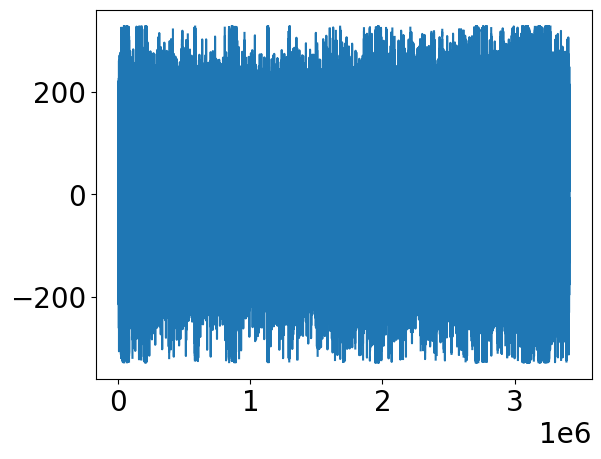

In [61]:
plt.plot(LFP_TRACES_DF["BLA_lfp_trace"].iloc[0])

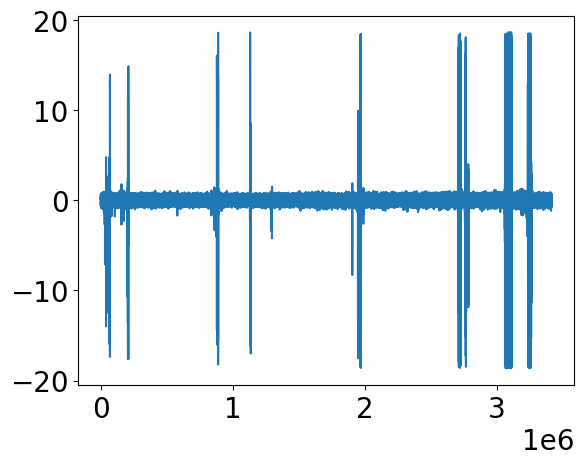

In [62]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS"].iloc[0])

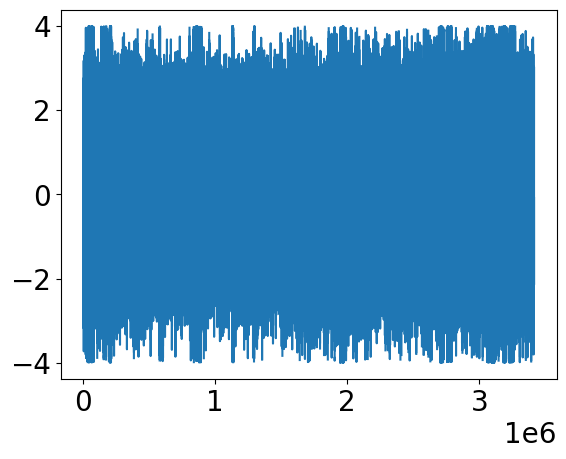

In [60]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS_filtered"].iloc[0])

In [ ]:
LFP_TRACES_DF["BLA_trace_power_all_frequencies_all_windows"].apply(lambda x: np.sum(np.isnan(x[:,3:13])))

In [ ]:
LFP_TRACES_DF["BLA_RMS_filtered_power_all_frequencies_all_windows"].apply(lambda x: np.sum(np.isnan(x[:,3:13])))

In [ ]:
raise ValueError()

In [ ]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/rce_pilot_2_02_full_spectral.pkl")
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

In [ ]:
raise ValueError()

## Calculating phase of signals

In [ ]:
from scipy.signal import butter, filtfilt, hilbert

- Filtering for theta and gamma

In [ ]:
RMS_columns = [col for col in LFP_TRACES_DF if "RMS" in col and "filtered" not in col]

In [ ]:
fs = 1000
order=4

In [ ]:
freq_band = [4, 12]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [ ]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_theta_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

In [ ]:
freq_band = [30, 50]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [ ]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_gamma_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

- Calculating the phase

In [ ]:
band_columns = [col for col in LFP_TRACES_DF if "band" in col]

In [ ]:
band_columns

In [ ]:
for col in band_columns:
    print(col)
    brain_region = col.replace("_band", "")
    updated_column = "{}_phase".format(brain_region)
    print(updated_column)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.angle(hilbert(x), deg=False))

In [ ]:
LFP_TRACES_DF[col]

In [ ]:
raise ValueError()

## Coherence Calculation

- Getting the trace column pairs

In [ ]:
trace_columns

In [ ]:
brain_region_pairs = generate_pairs(sorted(trace_columns))
brain_region_pairs = sorted(brain_region_pairs)


In [ ]:
brain_region_pairs

## Coherece Calculation

- Calculating the coherence

In [ ]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_coherence_multitaper"
        connectivity_col = f"{pair_base_name}_coherence_connectivity"
        frequencies_col = f"{pair_base_name}_coherence_frequencies"
        coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

        # Apply Multitaper function
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF.apply(
            lambda x: Multitaper(
                time_series=np.array([x[region_1], x[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            ), 
            axis=1
        )

        # Apply Connectivity function
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and coherence functions
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.coherence_magnitude()[:,:,0,1]
        )

        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float16))

    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

- Getting the timestamps of the coherence

In [ ]:
LFP_TRACES_DF["coherence_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for coherence makes sense with shape and values

In [ ]:
LFP_TRACES_DF["coherence_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["coherence_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

In [ ]:
LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_coherence.pkl")

# Calculate Granger's

In [ ]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    region_1_base_name = region_1.split('_')[0]
    region_2_base_name = region_2.split('_')[0]

    pair_base_name = f"{region_1_base_name}_{region_2_base_name}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_granger_multitaper"
        connectivity_col = f"{pair_base_name}_granger_connectivity"
        frequencies_col = f"{pair_base_name}_granger_frequencies"
        granger_1_2_col = f"{region_1_base_name}_{region_2_base_name}_granger_all_frequencies_all_windows"
        granger_2_1_col = f"{region_2_base_name}_{region_1_base_name}_granger_all_frequencies_all_windows"

        # Apply Multitaper function
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF.apply(
            lambda x: Multitaper(
                time_series=np.array([x[region_1], x[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            ), 
            axis=1
        )
    
        # Apply Connectivity function
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and granger functions
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.pairwise_spectral_granger_prediction()[:,:,0,1]
        )

        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.pairwise_spectral_granger_prediction()[:,:,1,0]
        )

        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[granger_1_2_col].apply(lambda x: x.astype(np.float16))
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[granger_2_1_col].apply(lambda x: x.astype(np.float16))
        
    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

- Getting the timestamps of the granger

In [ ]:
LFP_TRACES_DF["granger_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for granger makes sense with shape and values

In [ ]:
LFP_TRACES_DF["granger_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["granger_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

## Calculating the averages

In [ ]:
LFP_TRACES_DF.columns

In [ ]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/rce_pilot_2_02_full_spectral.pkl")
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

In [ ]:
raise ValueError()